<a href="https://colab.research.google.com/github/MarceloMedel/clase_productodatos_2019_udd/blob/master/ejemplo_clasificador_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a Pytorch usando fast.ai: 
# Clasificador de imágenes usando Google Images

*por Marcelo Medel, basado en la clase de Productos de Datos desarrollada por Alonso Astroza. [Github](https://github.com/aastroza/clase_productodatos_2019_udd)*

## Conseguir una lista de URLs

Para el desarrollo de este ejemplo se descargan imágenes desde Google Images.

Las búsquedas de imágenes hacen referencia a elementos de protección como gafas protectores o casco.

**Búsqueda de imágenes de personas gafa protectora**

https://www.google.com/search?q=human%20face%20glasses%20protection&tbm=isch&hl=es-419&hl=es-419&tbs=rimg%3ACeakF2I8IpR1YZ1PUiq9s9xz&sa=X&ved=0CBwQuIIBahcKEwiQ_KSc7YfrAhUAAAAAHQAAAAAQBw&biw=1680&bih=793

**Búsqueda de imágenes de personas casco**

https://www.google.com/search?q=person%20with%20protection%20helmet&tbm=isch&hl=es-419&hl=es-419&tbs=rimg%3ACdfaVnAvWQ5NYRfO9yN5ohYU&sa=X&ved=0CB4QuIIBahcKEwiosKu05IvrAhUAAAAAHQAAAAAQFA&biw=1866&bih=1035


**Búsqueda de imágenes de personas sin protector**

https://www.google.com/search?q=human%20face&tbm=isch&hl=es-419&hl=es-419&tbs=rimg%3ACed6jA_1e4j5EYU7998ZChm9k&sa=X&ved=0CBwQuIIBahcKEwiQ5Iue5IvrAhUAAAAAHQAAAAAQBw&biw=1866&bih=1035


### Bajar las imagenes a un archivo

Luego de encontrar un grupo de imágenes que nos pueda servir para entrenar el algoritmo, se debe hacer scroll del sitio hasta ver todos los resultados que pueda entregar Google Images.

Debemos correr un código Javascript en el navegador que guardará las URLs de todas las imágenes de nuestro dataset.

En Google Chrome hay que apretar <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> en Windows/Linux y <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> en macOS, y aparecerá la ventana de 'Console' javascript. En Firefox presionando <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> en Windows/Linux o <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> en macOS. Ahí es donde pegamos los comandos  JavaScript.

Antes de correr los comandos probablemente debamos deshabilitar cualquier extensión de ad blocking (uBlock, AdBlockPlus etc.) en Chrome. Si no, el comando window.open() no funciona. Luego se debe correr lo siguiente:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```


Los archivos .csv descargados se dejan almacenados en la carpeta `data`.

Ahora necesitaremos bajar las imagenes desde sus respectivas urls.

fast.ai tiene una función que permite hacer exactamente eso. Solo debemos especificarle el archivo con las urls así como una carpeta de destino, con eso la función va a bajar todas las imágenes que pueda abrir. Si tiene algún problema tratando de abrir algún archivo, simplemente se lo salta y no lo baja.

¡Así que bajemos las imágenes! Notemos que podemos elegir el número máximo de imágenes a bajar. En este caso no vamos a bajar todas las urls para que los conjuntos de datos sean más acotados.



In [227]:
!ls -l data

total 960
-rw-r--r--  1 mandmedel  staff   58267 Aug 10 12:47 casco-seguridad.csv
-rw-r--r--  1 mandmedel  staff   50811 Aug 10 12:47 gafa-protectora.csv
drwxr-xr-x@ 4 mandmedel  staff     128 Aug  9 12:00 models
-rw-r--r--  1 mandmedel  staff  225073 Aug  7 18:51 prueba.png
-rw-r--r--@ 1 mandmedel  staff   81468 Aug  9 11:59 prueba2.png
-rw-r--r--  1 mandmedel  staff   67577 Aug 10 12:48 sin-seguridad.csv
drwxr-xr-x  6 mandmedel  staff     192 Aug 10 10:51 train


In [230]:
from fastai.vision import *

La idea principal es poder detectar objetos que sean de protección, por tanto se harán clasificadores del tipo tiene/no tiene objeto de protección, implicando que se deberán hacer dos modelos en caso de quere detectar un caso y un lente de protección.

In [235]:
path = Path('data')
classes = ['casco-seguridad','gafa-protectora','sin-proteccion']
for _class in classes:
    file = _class+'.csv'
    dest_class = path/_class # path 
    dest_class.mkdir(parents=True, exist_ok=True) # crea un directorio con el nombre de la clase
    download_images(path/file, dest_class, max_pics=700) # descarga las imágenes
    print(f'{_class} downloaded')
    verify_images(path/_class, delete=True, max_size=700) # verificamos que las imagenes se puedan utilizar
    print(f'{_class} verified')

█casco-seguridad downloaded
█casco-seguridad verified
█gafa-protectora downloaded
█gafa-protectora verified
█sin-proteccion downloaded
█sin-proteccion verified


In [236]:
path.ls()

[PosixPath('data/casco-seguridad'),
 PosixPath('data/prueba2.png'),
 PosixPath('data/sin-proteccion.csv'),
 PosixPath('data/.DS_Store'),
 PosixPath('data/gafa-protectora'),
 PosixPath('data/models'),
 PosixPath('data/prueba.png'),
 PosixPath('data/sin-proteccion'),
 PosixPath('data/train'),
 PosixPath('data/casco-seguridad.csv'),
 PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/gafa-protectora.csv')]

## Preparación de datos para entrenar el modelo

* Lo primero es crear una carpeta con las imagenes que ocuparemos para entrenar el modelo, la carpeta en este caso se llama `train`.
* En la carpeta `train` dejaremos las imágenes con las que queremos entregar nuestro clasificador.
* En este ejemplo entrenaré el modelo para que clasifique imágenes de personas con casco de seguridad, por tanto se copian a la carpeta de `train` las imágenes de personas con cascos y las imágenes de caras de personas.

In [237]:
classes_train = ['casco-seguridad','sin-proteccion']
train = 'train'
path_train = path/train
if path_train.exists():
    !rm -r {path_train}
    path_train.mkdir()
    #print(f'rm {path_train}')
for _class in classes_train:
    path_class = path_train/_class
    path_class.mkdir(parents=True, exist_ok=True)
    path_data = path/_class
    !cp -r {path_data} {path_class}

In [239]:
np.random.seed(2)
data = ImageDataBunch.from_folder(path_train, train=".", valid_pct=0.3,
        ds_tfms=get_transforms(), size=224, num_workers=0).normalize(imagenet_stats)

Aprovechemos de mirar las imagenes que bajamos

In [240]:
data.classes

['casco-seguridad', 'sin-proteccion']

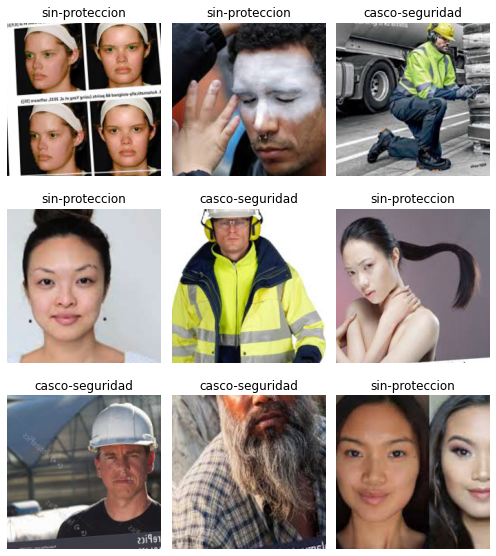

In [241]:
data.show_batch(rows=3, figsize=(7,8))

In [242]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['casco-seguridad', 'sin-proteccion'], 2, 852, 364)

## Entrenar el modelo

Para entrenar el modelo usaremos una [red neuronal convolucional](https://cs231n.github.io/convolutional-networks/) (resnet34). Por el momento lo necesario de saber es que estaremos construyendo un modelo que toma imágenes de entrada y como salida predice la probabilidad de que pertenezca a cada categoría.

Entrenaremos por 4 épocas (4 ciclos por todos los datos).

In [243]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [244]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [245]:
learn.fit_one_cycle(4)

█epoch     train_loss  valid_loss  error_rate  time    
██0         0.369526    0.072939    0.013736    04:21     
██1         0.178564    0.015549    0.005495    04:08     
██2         0.111710    0.009858    0.005495    04:11     
██3         0.074431    0.006412    0.002747    04:11     


In [246]:
learn.save('stage-1')

## Resultados

Veamos los resultados que obtuvimos.

Primero miraremos si lo que predijo el modelo es razonable o no. Si no obtiene resultados que son descabellados es un buen indicador que el clasificador esta funcionando bien.

Además graficaremos la matriz de confusión.

In [247]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

█

True

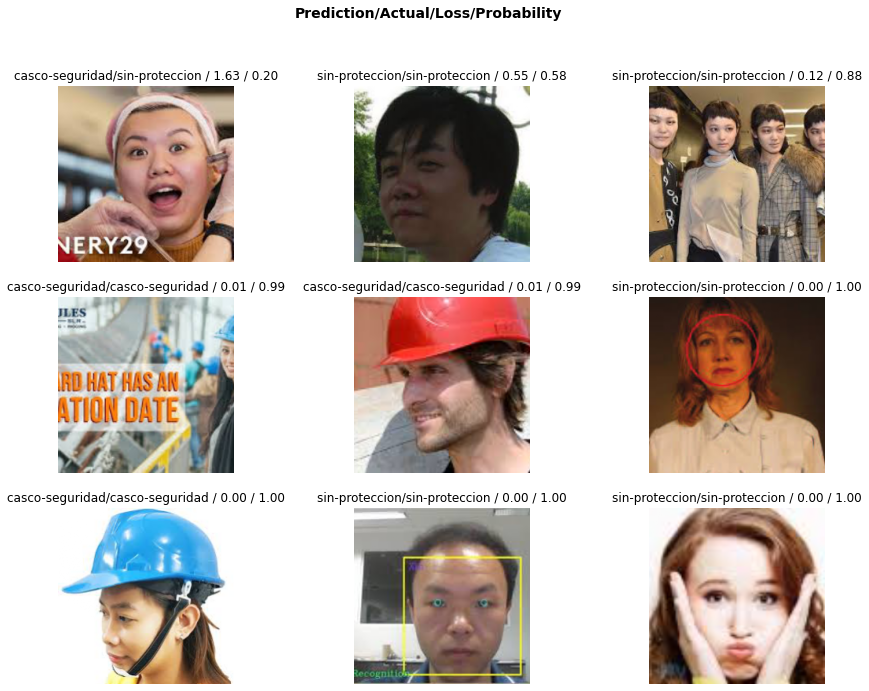

In [248]:
interp.plot_top_losses(9, figsize=(15,11))

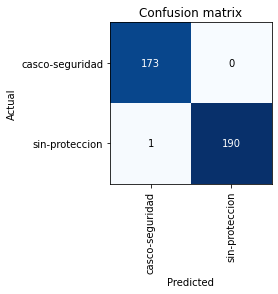

In [249]:
interp.plot_confusion_matrix()

Para predecir basta con usar la CPU, excepto a escala masiva (o entrenamiento en línea). Si la máquina donde publicaremos el modelo no tiene GPU, el cambio a CPU se realizará de manera automática. Tambien podemos probar el modelo en CPU de esta forma:

In [250]:
defaults.device = torch.device('cpu')

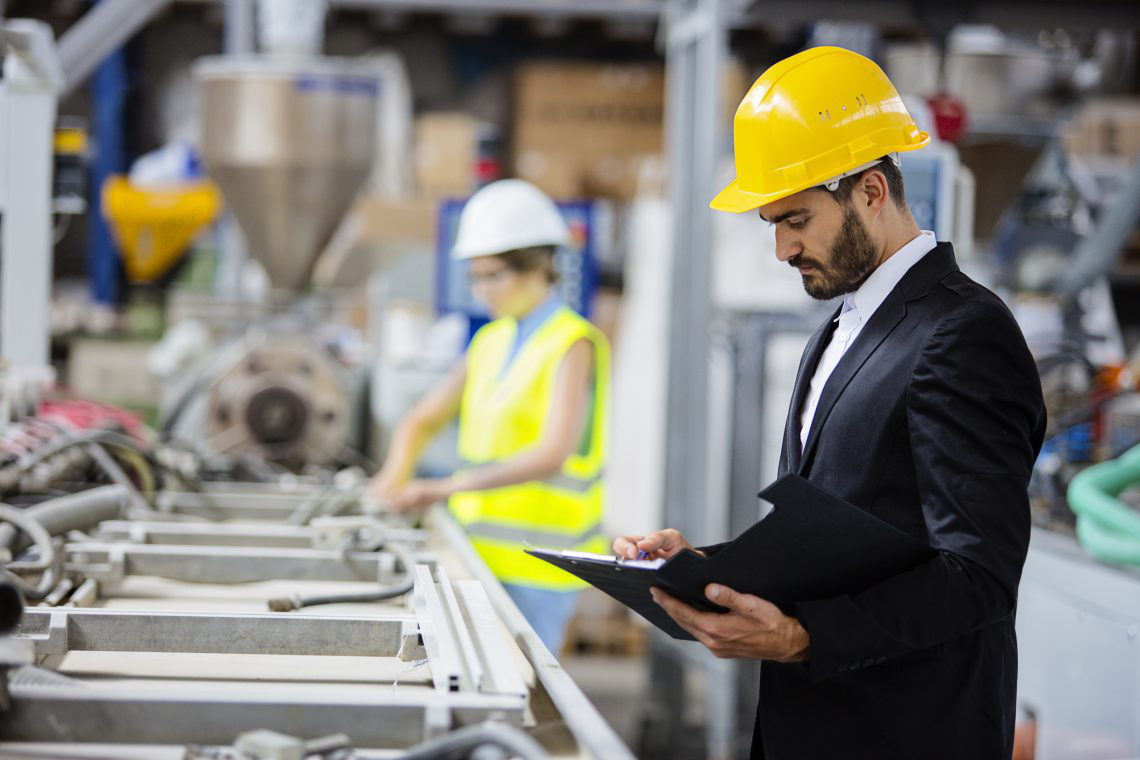

In [255]:
img = open_image(path/'prueba-casco.jpg')
img

In [256]:
pred_class,pred_idx,outputs = learn.predict(img)
str(pred_class)

'casco-seguridad'

In [257]:
outputs

tensor([1.0000e+00, 1.2577e-13])

## Poniendo el modelo en producción

Primero hay que exportar el contenido del objeto `Learner` para usarlo en producción:

* Se genera una copia del modelo anterior con la fecha de ejecución del respaldo
* Se crea el archivo *export.pkl* con la variable `model`
* El archivo *export.pkl* contiene todo lo necesario para publicar nuestro modelo (el modelo, los pesos de la red y alguna metadata como las clases o las transformaciones/normalizaciones realizadas).

In [259]:
learn.export()

In [260]:
!cp data/train/export.pkl models/